# Kaggle Loan Prediction Competition

The goal for this competition is to create a model that can predict whether an applicant is approved for a loan.
https://www.kaggle.com/competitions/loan-approval-quantitativedata/data

## Packages

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
import os
import itertools
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings

In [2]:
import statsmodels.tsa.api as tsa
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split
import pmdarima as pm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn import set_config

## Functions

In [3]:
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [4]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    

In [5]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

## Data

In [7]:
loan_data = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/kaggle-loan-prediction/credit_risk_dataset.csv')

In [8]:
loan_data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [9]:
loan_data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [10]:
loan_data.tail()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26
32580,66,42000,RENT,2.0,MEDICAL,B,6475,9.99,0,0.15,N,30


In [11]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [12]:
loan_data.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

### Variables

Variables

- loan_data
- approved_loans / status_0
- denied_loans / status_1
- loan_test
- loan_train

## Inspect Columns

### person_age

In [13]:
loan_data['person_age'].unique()

array([ 22,  21,  25,  23,  24,  26, 144, 123,  20,  32,  34,  29,  33,
        28,  35,  31,  27,  30,  36,  40,  50,  45,  37,  39,  44,  43,
        41,  46,  38,  47,  42,  48,  49,  58,  65,  51,  53,  66,  61,
        54,  57,  59,  62,  60,  55,  52,  64,  70,  78,  69,  56,  73,
        63,  94,  80,  84,  76,  67])

### person_income

In [14]:
loan_data['person_income'].unique()

array([  59000,    9600,   65500, ...,  720000, 1900000,    4888])

In [15]:
loan_data['person_income'].min()

4000

In [16]:
loan_data['person_income'].max()

6000000

### person_home_ownership 

### person_emp_length

In [17]:
loan_data['person_income'].unique()

array([  59000,    9600,   65500, ...,  720000, 1900000,    4888])

In [18]:
loan_data['person_home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object)

### loan_intent

In [19]:
loan_data['loan_intent'].unique()

array(['PERSONAL', 'EDUCATION', 'MEDICAL', 'VENTURE', 'HOMEIMPROVEMENT',
       'DEBTCONSOLIDATION'], dtype=object)

### loan_grade

In [20]:
loan_data['loan_grade'].unique()

array(['D', 'B', 'C', 'A', 'E', 'F', 'G'], dtype=object)

In [21]:
loan_data['loan_grade'].value_counts()

A    10777
B    10451
C     6458
D     3626
E      964
F      241
G       64
Name: loan_grade, dtype: int64

### loan_amnt

In [22]:
loan_data['loan_amnt'].unique()

array([35000,  1000,  5500,  2500,  1600,  4500, 30000,  1750, 34800,
       34000,  1500, 33950, 33000,  4575,  1400, 32500,  4000,  2000,
       32000, 31050, 24250,  7800, 20000, 10000, 25000, 18000, 12000,
       29100, 28000,  9600,  3000,  6100,  4200,  4750,  4800,  2700,
       27600,  3250, 27500, 27050, 27000, 26000, 25600, 25475, 21600,
       11900, 25300,  3650,  6000,  2400,  3600,  7500,  4950, 21000,
       16000, 22000,  7750, 24000, 15000, 15500,  9000, 23050,  5375,
        6250,  5000,  2100, 14000,  6200,  9950,  4475,  2600,  8000,
        4600,  3500,  7200,  8800,  3175,  2800, 13000,  1800,  3300,
        3200,  2275,  5600,  3625,  4375, 24750, 24500,  3900, 13750,
       15250, 24150,  2250,  4975,  4900, 23975, 23750, 23600, 23575,
        5400,  3375, 23400, 23000,  1200, 22750, 22500, 22400, 22250,
        7400, 21700,  7000, 21500, 21450, 21250,  9250, 20900, 20500,
       20400, 20375, 20050,  6400,  5650, 16600,  7125,  3550,  1275,
        3800,  1625,

### loan_int_rate

In [23]:
loan_data['loan_int_rate'].unique()

array([16.02, 11.14, 12.87, 15.23, 14.27,  7.14, 12.42, 11.11,  8.9 ,
       14.74, 10.37,  8.63,  7.9 , 18.39, 10.65, 20.25, 18.25, 10.99,
        7.49, 16.77, 17.58,  7.29, 14.54, 12.68, 17.74,  9.32,  9.99,
       12.84, 11.12,  6.62, 14.17, 13.85, 13.49,  7.51, 16.89,   nan,
       17.99, 12.69,  7.88, 19.41, 10.38, 15.33, 16.45, 18.62, 15.96,
       11.48,  5.99, 11.58, 15.7 , 15.99, 14.84, 14.42,  6.99, 13.61,
        9.91, 13.48, 12.98, 13.57, 15.68, 13.06, 15.62, 11.71,  8.88,
       12.18, 13.99,  5.42, 12.73, 11.49, 19.91, 11.83, 14.59,  9.64,
       16.35, 18.67, 10.08, 10.36, 12.23, 16.07, 14.22, 14.79, 13.22,
       11.86, 13.43, 15.28, 17.93,  9.25, 10.62, 18.43, 11.36, 15.65,
       13.04, 17.04, 14.83, 14.65, 16.82, 10.25, 14.96, 11.99,  8.49,
        6.17, 16.32, 14.35, 15.21, 14.09, 17.49, 13.92, 16.49,  5.79,
       13.11,  6.54, 12.53, 15.95, 10.74, 15.27, 14.72, 13.35,  7.68,
       14.46, 13.47,  6.03, 12.92, 18.64, 16.7 , 18.3 ,  9.63, 14.7 ,
       15.37, 14.26,

### loan_status 

In [24]:
loan_data['loan_status'].unique()

array([1, 0])

### loan_percent_income

In [25]:
loan_data['loan_percent_income'].unique()

array([0.59, 0.1 , 0.57, 0.53, 0.55, 0.25, 0.45, 0.44, 0.42, 0.16, 0.41,
       0.37, 0.32, 0.3 , 0.06, 0.29, 0.31, 0.22, 0.52, 0.14, 0.49, 0.13,
       0.5 , 0.35, 0.17, 0.27, 0.33, 0.08, 0.03, 0.21, 0.63, 0.47, 0.4 ,
       0.07, 0.38, 0.34, 0.04, 0.23, 0.15, 0.11, 0.43, 0.51, 0.02, 0.28,
       0.26, 0.19, 0.39, 0.09, 0.05, 0.61, 0.18, 0.6 , 0.01, 0.48, 0.12,
       0.54, 0.56, 0.46, 0.36, 0.24, 0.2 , 0.72, 0.64, 0.69, 0.77, 0.83,
       0.65, 0.67, 0.58, 0.71, 0.68, 0.7 , 0.66, 0.  , 0.76, 0.62, 0.78])

### cb_person_default_on_file 

In [26]:
loan_data['cb_person_default_on_file'].unique()

array(['Y', 'N'], dtype=object)

### cb_person_cred_hist_length

In [27]:
loan_data['cb_person_cred_hist_length'].unique()

array([ 3,  2,  4,  8,  7,  6,  9, 10,  5, 11, 16, 15, 12, 13, 17, 14, 25,
       28, 27, 22, 19, 29, 23, 26, 20, 21, 30, 24, 18])

## EDA

### Loan approval vs denial

In [28]:
# separate data by loan status in order to figure out which are approved and which are not
loan_data.groupby(['loan_status']).count()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
loan_status,,,,,,,,,,,
0,25473,25473,25473,24860,25473,25473,25473,23001,25473,25473,25473
1,7108,7108,7108,6826,7108,7108,7108,6464,7108,7108,7108


#### status 1

In [29]:
status_1 = loan_data.loc[loan_data['loan_status'] > 0]
status_1

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...
32563,52,71520,RENT,0.0,EDUCATION,E,7000,16.82,1,0.10,Y,24
32565,57,40000,RENT,1.0,MEDICAL,A,15000,8.90,1,0.38,N,21
32571,60,45600,RENT,1.0,VENTURE,B,20000,10.00,1,0.44,N,26
32574,52,65004,RENT,4.0,PERSONAL,D,20000,15.58,1,0.31,Y,19


In [30]:
status_1['loan_grade'].unique()

array(['D', 'C', 'A', 'B', 'E', 'F', 'G'], dtype=object)

In [31]:
status_1['loan_grade'].value_counts()

D    2141
B    1701
C    1339
A    1073
E     621
F     170
G      63
Name: loan_grade, dtype: int64

In [32]:
status_1['cb_person_default_on_file'].value_counts()

N    4936
Y    2172
Name: cb_person_default_on_file, dtype: int64

In [33]:
status_1['person_income'].min()

4000

In [34]:
status_1['person_income'].max()

703800

In [35]:
status_1['person_home_ownership'].value_counts()

RENT        5192
MORTGAGE    1690
OWN          193
OTHER         33
Name: person_home_ownership, dtype: int64

#### Status 0

In [36]:
status_0 = loan_data.loc[loan_data['loan_status'] < 1]
status_0

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
14,23,115000,RENT,2.0,EDUCATION,A,35000,7.90,0,0.30,N,4
15,23,500000,MORTGAGE,7.0,DEBTCONSOLIDATION,B,30000,10.65,0,0.06,N,3
16,23,120000,RENT,0.0,EDUCATION,A,35000,7.90,0,0.29,N,4
20,25,162500,RENT,2.0,VENTURE,A,35000,7.49,0,0.22,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32575,52,64500,RENT,0.0,EDUCATION,B,5000,11.26,0,0.08,N,20
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [37]:
status_0['loan_grade'].unique()

array(['B', 'A', 'E', 'C', 'F', 'D', 'G'], dtype=object)

In [38]:
status_0['loan_grade'].value_counts()

A    9704
B    8750
C    5119
D    1485
E     343
F      71
G       1
Name: loan_grade, dtype: int64

In [39]:
status_0['cb_person_default_on_file'].value_counts()

N    21900
Y     3573
Name: cb_person_default_on_file, dtype: int64

In [40]:
status_0['person_income'].min()

7000

In [41]:
status_0['person_income'].max()

6000000

In [42]:
status_0['person_home_ownership'].value_counts()

MORTGAGE    11754
RENT        11254
OWN          2391
OTHER          74
Name: person_home_ownership, dtype: int64

#### results

In [43]:
# based off of these findings, it can be concluded that status_1 is a denied loan & status_0 is an approved loan

In [44]:
denied_loans = status_1
denied_loans

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...
32563,52,71520,RENT,0.0,EDUCATION,E,7000,16.82,1,0.10,Y,24
32565,57,40000,RENT,1.0,MEDICAL,A,15000,8.90,1,0.38,N,21
32571,60,45600,RENT,1.0,VENTURE,B,20000,10.00,1,0.44,N,26
32574,52,65004,RENT,4.0,PERSONAL,D,20000,15.58,1,0.31,Y,19


In [45]:
approved_loans = status_0
approved_loans

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
14,23,115000,RENT,2.0,EDUCATION,A,35000,7.90,0,0.30,N,4
15,23,500000,MORTGAGE,7.0,DEBTCONSOLIDATION,B,30000,10.65,0,0.06,N,3
16,23,120000,RENT,0.0,EDUCATION,A,35000,7.90,0,0.29,N,4
20,25,162500,RENT,2.0,VENTURE,A,35000,7.49,0,0.22,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32575,52,64500,RENT,0.0,EDUCATION,B,5000,11.26,0,0.08,N,20
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [46]:
denied_loans['person_emp_length'].value_counts()

0.0      1147
2.0       987
1.0       806
3.0       696
4.0       610
5.0       548
6.0       500
7.0       412
8.0       281
9.0       244
11.0      136
10.0      119
12.0       90
14.0       56
13.0       51
15.0       43
17.0       22
16.0       20
20.0       13
18.0       11
21.0       10
19.0        9
22.0        3
24.0        3
23.0        3
34.0        1
29.0        1
123.0       1
27.0        1
26.0        1
30.0        1
Name: person_emp_length, dtype: int64

In [47]:
approved_loans['person_emp_length'].value_counts()

0.0      2958
2.0      2862
3.0      2760
5.0      2398
4.0      2264
6.0      2166
1.0      2109
7.0      1784
8.0      1406
9.0      1123
11.0      604
10.0      577
12.0      485
13.0      375
14.0      279
15.0      195
16.0      145
17.0      107
18.0       93
19.0       55
20.0       29
21.0       28
22.0       16
25.0        8
23.0        7
24.0        7
26.0        5
27.0        4
31.0        4
28.0        3
123.0       1
41.0        1
38.0        1
30.0        1
Name: person_emp_length, dtype: int64

In [48]:
# 7108 loans were denied
# 25473 loans were approved

In [49]:
denied_loans.isna().sum()

person_age                      0
person_income                   0
person_home_ownership           0
person_emp_length             282
loan_intent                     0
loan_grade                      0
loan_amnt                       0
loan_int_rate                 644
loan_status                     0
loan_percent_income             0
cb_person_default_on_file       0
cb_person_cred_hist_length      0
dtype: int64

In [50]:
approved_loans.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              613
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 2472
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

## Modeling

In [51]:
loan_train = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/kaggle-loan-prediction/Sample files/train.csv')

In [52]:
loan_test = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/kaggle-loan-prediction/Sample files/test.csv')

In [53]:
loan_train

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10,0
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8,1
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2,1
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3,0


In [54]:
loan_test

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
39093,97738,22,31200,MORTGAGE,2.0,DEBTCONSOLIDATION,B,3000,10.37,0.10,N,4
39094,97739,22,48000,MORTGAGE,6.0,EDUCATION,A,7000,6.03,0.15,N,3
39095,97740,51,60000,MORTGAGE,0.0,PERSONAL,A,15000,7.51,0.25,N,25
39096,97741,22,36000,MORTGAGE,4.0,PERSONAL,D,14000,15.62,0.39,Y,4


In [55]:
loan_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [56]:
loan_train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [57]:
loan_train.isna().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [58]:
loan_train.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [59]:
loan_train.corr()

/var/folders/jx/cpydz30j3y523cvb2w4sjv7h0000gn/T/ipykernel_3950/2213753118.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  loan_train.corr()


,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
id,1.000000,0.008608,-0.001896,0.005376,-0.000403,-0.003454,-0.002677,0.008139,-0.008138
person_age,0.008608,1.000000,0.102176,0.121276,0.050378,0.009653,-0.031975,0.874260,-0.001130
person_income,-0.001896,0.102176,1.000000,0.164042,0.310942,-0.057611,-0.280314,0.082727,-0.169956
person_emp_length,0.005376,0.121276,0.164042,1.000000,0.092046,-0.101910,-0.065824,0.102842,-0.100428
loan_amnt,-0.000403,0.050378,0.310942,0.092046,1.000000,0.113582,0.647266,0.045720,0.144982
loan_int_rate,-0.003454,0.009653,-0.057611,-0.101910,0.113582,1.000000,0.152201,0.007535,0.338948
loan_percent_income,-0.002677,-0.031975,-0.280314,-0.065824,0.647266,0.152201,1.000000,-0.023202,0.378280
cb_person_cred_hist_length,0.008139,0.874260,0.082727,0.102842,0.045720,0.007535,-0.023202,1.000000,-0.003030
loan_status,-0.008138,-0.001130,-0.169956,-0.100428,0.144982,0.338948,0.378280,-0.003030,1.000000


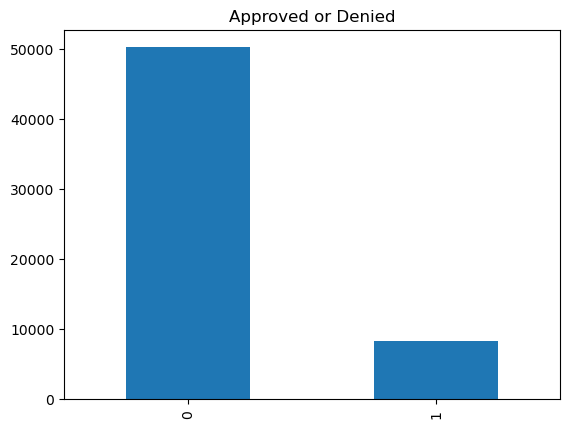

In [78]:
loan_train['loan_status'].value_counts().plot.bar(title='Approved or Denied');

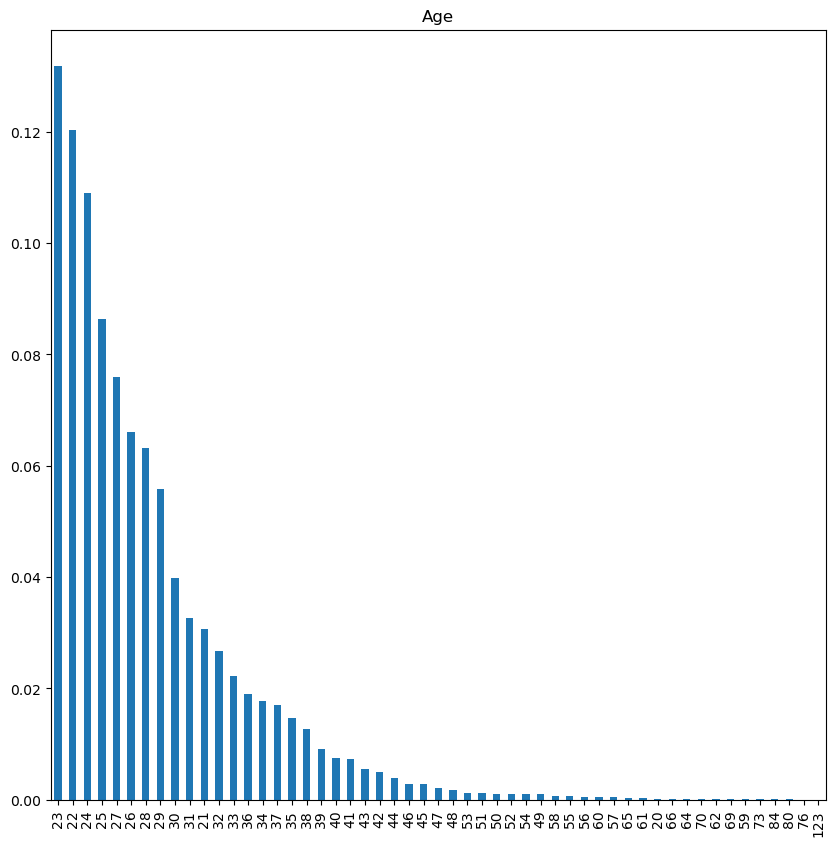

In [73]:
plt.subplot()
loan_train['person_age'].value_counts(normalize=True).plot.bar(figsize=(10, 10), title='Age');

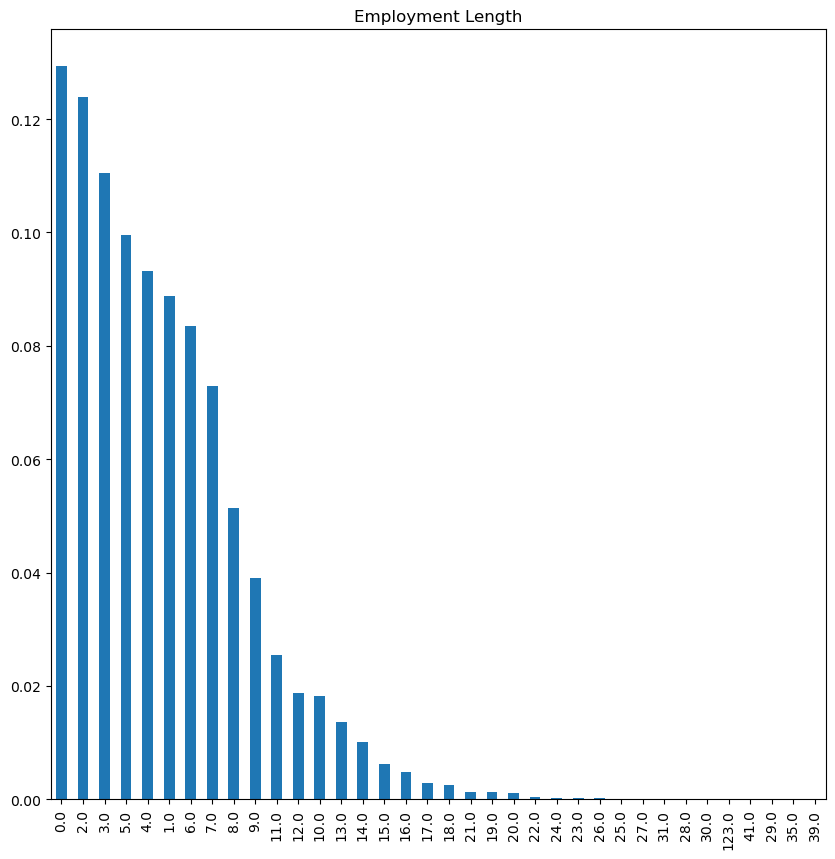

In [76]:
plt.subplot()
loan_train['person_emp_length'].value_counts(normalize=True).plot.bar(figsize=(10, 10), title='Employment Length');

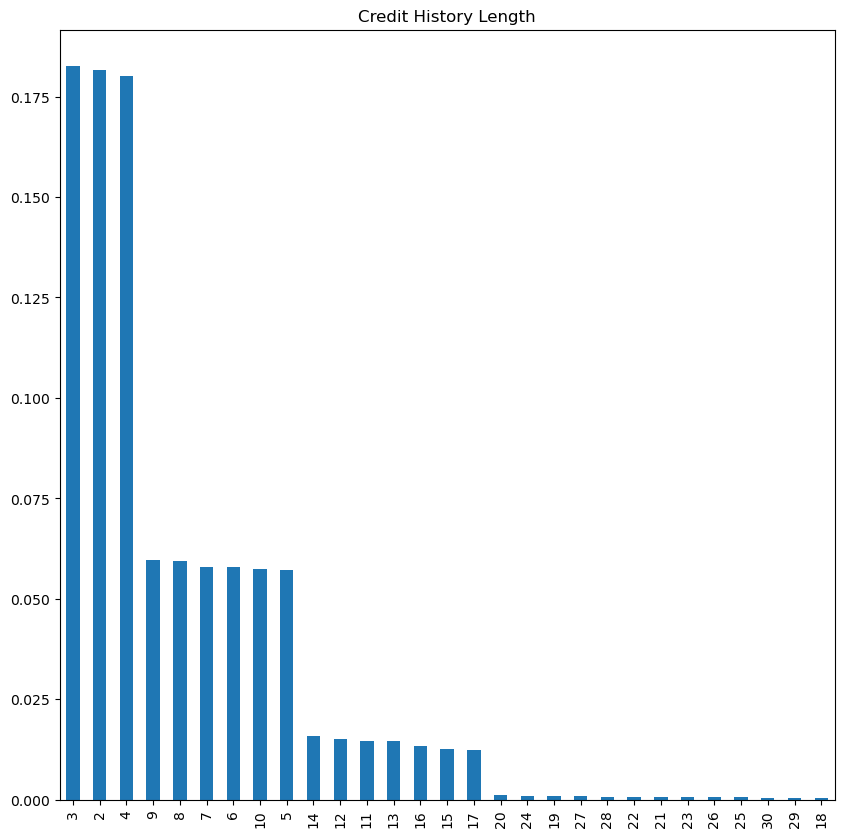

In [77]:
plt.subplot()
loan_train['cb_person_cred_hist_length'].value_counts(normalize=True).plot.bar(figsize=(10, 10), title='Credit History Length');

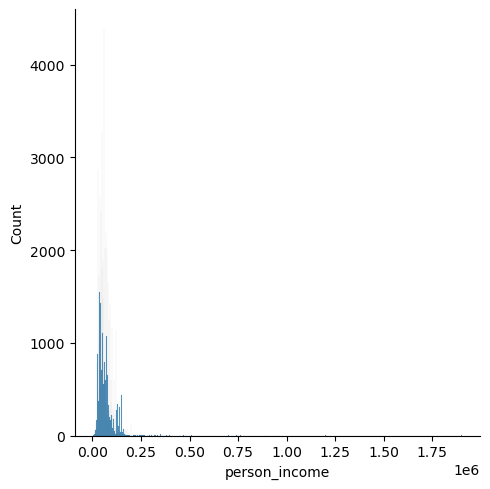

In [88]:
plt.subplot
sns.displot(loan_train['person_income']);

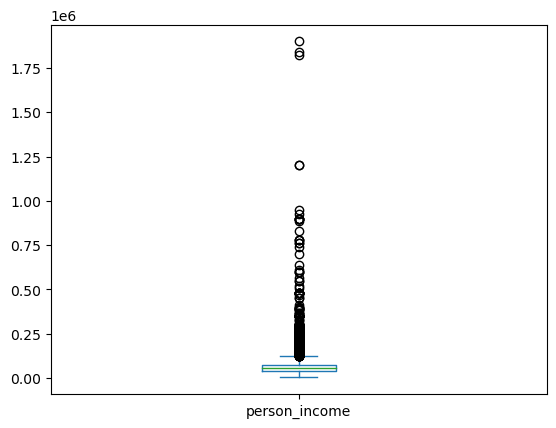

In [90]:
plt.subplot
loan_train['person_income'].plot.box();

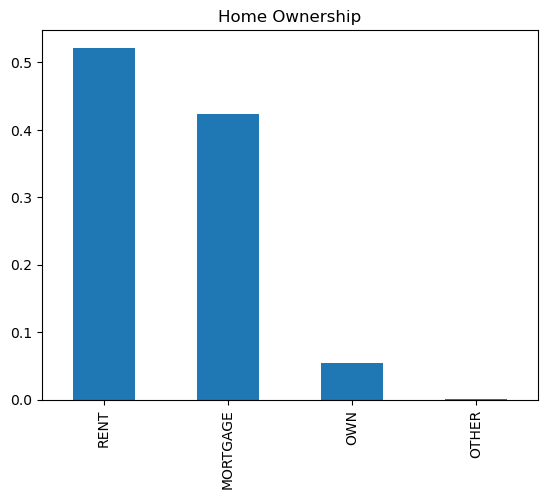

In [83]:
plt.subplot
loan_train['person_home_ownership'].value_counts(normalize=True).plot.bar(title = 'Home Ownership');

In [80]:
loan_train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


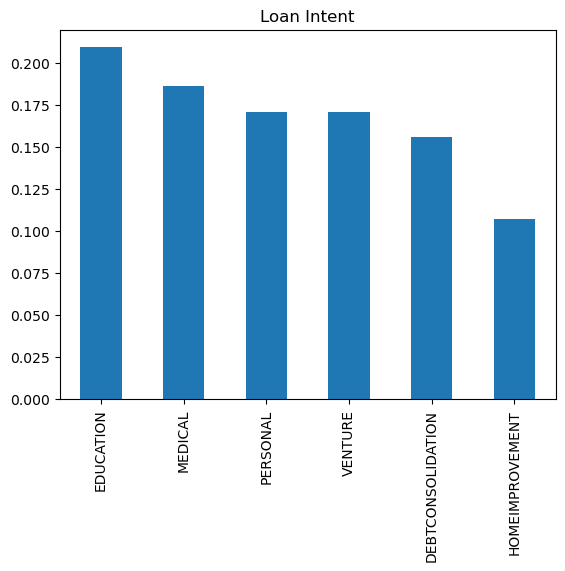

In [84]:
plt.subplot
loan_train['loan_intent'].value_counts(normalize=True).plot.bar(title = 'Loan Intent');